# Лабораторная работа 2. Вероятностные модели.

Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете также должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам — проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.

Мы уверены, что выполнение лабораторных работ занимает значительное время, поэтому не рекомендуем оставлять их на последний вечер перед сдачей.

### Оценивание и штрафы
* Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи)
* Максимально допустимая оценка за работу — 15 баллов. Также в результате выполнения заданий у вас получится решение [задачи конкурса](https://www.kaggle.com/c/competition-2-yandex-shad-spring-2021), которое после небольшой доработки принесёт ещё 5 баллов за пробитие Medium Baseline.
* Сдавать задание после указанного срока сдачи нельзя
* «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму (подробнее о плагиате см. на странице курса)
* Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник)
* Не оцениваются задания с удалёнными формулировками
* Не оценивается лабораторная работа целиком, если она была выложена в открытый источник

Обратите внимание, что мы не ставим оценку за просто написанный код, корректная работоспособность которого не подтверждена экспериментами.


Цель этой лабораторной работы – научиться строить вероятностные модели и оптимизировать их параметры на примере задачи оценки риска заболевания сахарным диабетом. На задачу оценки риска болезни мы посмотрим со стороны страховой компании.

Если человек перестанет проходить обследования, и страховая так и не узнает, развился ли у него диабет, то и расходов, связанных с его заболеванием не будет, т.е. можно считать, что такой человек остался здоров. То же касается людей, у которых заболевание впервые обнаружат более чем через 5 лет.

Чтобы рассчитать математическое ожидание затрат на лечение клиента, страховая хочет получить в качестве результата работы модели непосредственно вероятность того, что у человека, не страдающего от заболевания, оно разовьётся в течение 5 лет. Поэтому в качестве метрики качества была выбрана бинарная кросс-энтропия (она же logloss) между предсказанными вероятностями и истинными метками классов:


$$\text{crossentropy}(y, p) = -\frac{1}{N}\sum_{i=1}^N\left[y_i\log(p_i) + (1-y_i)\log(1-p_i)\right]$$



In [52]:
import pandas as pd
from sklearn import linear_model
from sklearn import metrics
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
import time
import torch.nn.functional as F
import seaborn as sns

**Задание 1** Препроцессинг (1 балл) 

- Прочитайте описание [набора данных и задачи конкурса 2](https://www.kaggle.com/c/competition-2-yandex-shad-spring-2021).
- Загрузите обучающий набор данных (X_train.csv, y_train.csv).
- Обратите внимание, что часть информации о клиентах неизвестна на момент заключения договора. Соответствующие признаки отсутствуют в X_test.csv.
- Заполните пропуски в данных. Для этого могут пригодиться методы из sklearn.impute или pandas.DataFrame.fillna.
- По желанию используйте любой препроцессинг данных, добавляйте новые признаки и т.п. ваша задача — добиться сходимости и высокого качества полученных моделей.
- Разбейте обучающую выборку на lab_train и lab_test, которые будете использовать для оценки всех построенных моделей в лабораторной работе. При желании использовать для оценки качества кросс-валидацию необходимо проконтролировать, чтобы для всех моделей использовались одни и те же разбиения.

In [182]:
X_raw = pd.read_csv('X_train.csv')
y_raw = pd.read_csv('y_train.csv')

In [183]:
def preprocessing_X(X, y=None):
    X = X.join(pd.get_dummies(X['Gender']).rename(columns={1 : 'Male', 2 : 'Female'}))
    X = X.drop(columns = ['Gender'])
    X = X.join(pd.get_dummies(X['site'], prefix='site'))
    X = X.drop(columns = ['site'])
    X = X.join(pd.get_dummies(X['smoking status'], prefix='smoking status'))
    X = X.drop(columns = ['smoking status'])
    X = X.join(pd.get_dummies(X['drinking status'], prefix='drinking status'))
    X = X.drop(columns = ['drinking status'])

    analysis = ['height', 'weight', 'Body Mass Index', 'Systolic blood pressure',
           'diastolic blood pressure', 'Fasting plasma glucose', 'Cholesterol',
           'Triglyceride', 'High-density lipoprotein cholesterol ',
           'Low-density lipoprotein cholesterol', 'Alanine aminotransferase',
           'Aspartate transaminase', 'Blood urea nitrogen',
           'Creatinine clearance rate']

    for name in analysis:
        mean_value = X[name].mean()
        X[name].fillna(mean_value, inplace=True)
    
    if y is not None:
        X['target'] = y['diabettes in 5 years']
    
    def multiply_rows(X):
        X_copy = X.copy()
        X_copy['years_during_start'] = X_copy['year of followup'].astype(int)
        for i in range(6):
            X_copy = X_copy.append([X_copy[X_copy['years_during_start'] == i]] * i, ignore_index=True)
        X_copy.drop(columns=['years_during_start'])
        return X_copy
        
    #X = multiply_rows(X)
    return X

In [184]:
X = preprocessing_X(X_raw, y_raw)

In [185]:
def drop_secret_data(X):
    return np.array(X.drop(columns=['Fasting plasma glucose (final visit)',
       'Diabetes diagnosed during followup', 'censor of diabetes at followup',
       'year of followup', 'target'])), np.array(X['target']).reshape(-1)

X_matrix, y_matrix = drop_secret_data(X)

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X_matrix, y_matrix, test_size=0.2)

In [187]:
def compute_log_loss(X, y):
    X = torch.FloatTensor(X).to(device=device)
    y = torch.LongTensor(y).to(device=device)
    logits = net.to(device)(X)
    logits = torch.cat((1 - logits, logits), dim=1)
    return metrics.log_loss(y, logits.data)

**Задание 2** Бэйзлайн – константное предсказание (0.5 балла).

Как понять, работает ли та или иная модель, если сравить метрику не с чем? Чтобы было с чем сравнивать, соберём простой бэйзлайн: предскажем всем клиентам одну и ту же вероятность заболеть в течение 5 лет. Какое значение надо предсказать, чтобы минимизировать кросс-энтропию? Оцените качество такого предсказания.

Ну, там в лоб формула выписывается, берется произовдная по p, ищется корень и(о чудо) получается, что потимальная вероятность - среднее по выборке

In [188]:
p = len(X[X['target'] == 1]) / len(X)

In [189]:
metrics.log_loss(y_test, np.ones(y_test.shape) * p)

0.09253942411261205

**Задание 3** Наивный байесовский классификатор (0.5 балла).

Предположим, что в каждом из классе признаки независимы и имеют нормальное распределение. Тогда подобрать параметры этого распределения поможет модель [Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html). Обучите эту модель. Оцените её качество.





In [190]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB()

In [191]:
y_pred = clf.predict_proba(X_test)

In [192]:
metrics.log_loss(y_test, y_pred[:, 1])

2.24048014171245

**Задание 4** Дискриминантный анализ (1 балл).

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_lda_qda_001.png)

Теперь избавимся от предположения условной независимости признаков относительно целевой переменной. Таким образом, ковариационные матрицы распределений классов не обязательно будут даигональны. Мы можем наложить дополнительное условие в виде [равенства ковариационных матриц](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis) всех классов или [не делать этого](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis).

Попробуйте оба варианта. Какой сработал лучше и чем это можно объяснить?


**Задание 5** Логистическая регрессия (1 балл).

Обучите модель логистической регрессии. Убедитесь, что модель сошлась. Удалось ли получить улучшение по сравнению с предыдущими моделями? Чем это можно объяснить?

In [193]:
LR = linear_model.LogisticRegression().fit(X_train, y_train)
y_pred = LR.predict_proba(X_test)
metrics.log_loss(y_test, y_pred[:, 1])

/home/captainbanana/virtual_envs/deep_learning/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.06224477692179824

**Задание 6** GLM – обобщённые линейные модели (1 балл).

Как вы знаете, логистическая регрессия является частным случаем обобщённой линейной модели $\mu(\mathbb E(y|X)) = Xw$, где функция связи $\mu(u) = \log(\frac{u}{1-u})$, и $y|X\sim Bernoulli$.

Учитывая, что целевая переменная бинарная, изменять класс распределений $y|X$ не имеет смысла. А вот изменить функцию связи можно.

Обучите обобщённые линейные модели, в качестве функции связи использовав по крайней мере 2 разные функции, отличные от logit, использующейся в логистической регрессии.

Реализацию GLM можно взять в пакете [statsmodels](https://www.statsmodels.org/stable/glm).



In [194]:
import statsmodels.api as sm
probit_model = sm.GLM(y_train, X_train, family=sm.families.Binomial(sm.families.links.probit()))
probit_results = probit_model.fit()

In [195]:
y_pred = probit_results.predict(X_test)
metrics.log_loss(y_test, y_pred)

0.0615192693633211

In [206]:
cloglog_model = sm.GLM(y_train, X_train, family=sm.families.Binomial(sm.families.links.cloglog()))
cloglog_results = cloglog_model.fit()


In [207]:
y_pred = cloglog_results.predict(X_test)
metrics.log_loss(y_test, y_pred)

0.061886785394978085

В этой части работы мы построим теперь вероятностную модель, учитывающую специфику задачи.

**Задание 7** Оценка Нельсона – Аалена (1 балл).

Поскольку изначально все участники исследования были здоровы, заболеть, скажем, через месяц у них очень мало шансов. Скорее всего, это значило бы ошибку при проведении анализов. А вот заболеть через несколько лет шансов уже больше.

Зависимость риска заболеть в данный момент времени $t$ при условии, что до момента $t$ человек оставался здоров, называется функцией риска ([hazard function](https://en.wikipedia.org/wiki/Survival_analysis#Hazard_function_and_cumulative_hazard_function)). В других задачах она позволяет определить, люди какого возраста наиболее подвержены заболеванию, или в какой момент эпидемии риск заразиться максимален.

Оцените, какова вероятность заболеть через $t$ лет после начала исследования, воспользовавшись оценками Нельсона – Аалена:

$$\hat H_{NA}(t) = \frac{d_t}{n_t},$$

Где $n_t$ – количество участников, остававшихся здоровыми и не прекративших участие в исследовании до года $t$, $d_t$ – количество участников, заболевших в год $t.$

Изобразите $\hat H_{NA}(t)$ на графике.

In [221]:
probs = []
for t in range(2, 5):
    prob = len(X[(t <= X['year of followup']) & (X['year of followup'] < t+1) & (X['target'] == 1)]) / len(X[(X['target'] == 0) & (t <= X['year of followup'])])
    probs.append(prob)

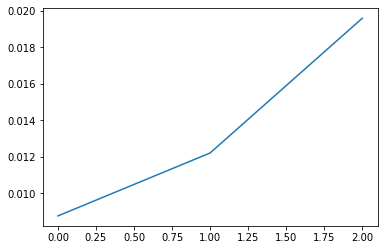

In [223]:
plt.plot(probs)

Оценка Нельсона – Аалена не персонализирована, т.е. для неё мы никак не использовали признаки пациентов.

Модель пропорциональных рисков Кокса (Cox Proportional Hazard Model, CPHM) моделирует отношение риска для пациента к среднему риску по всем пациентам для данного момента времени. Поскольку это отношение рисков – положительное число, его обычно моделируют как $e^{Xw}$, где $X$ – признаки пациентов, $w$ – обучаемый вектор весов. Таким образом,

$$\hat H_{Cox}(x, t) = \hat H_{NA}(t)e^{xw}.$$

Обратите внимание, что в линейной части CPHM не используют свободный член: в некотором смысле его роль играет $\hat H_{NA}(t)$.

Вероятность заболеть ровно в момент $t$ – это произведение вероятности не заболеть до момента $t$ на вероятность заболеть в момент $t$ при условии здоровья до момента $t$. Таким образом, функция правдоподобия имеет вид

$$L = \prod_{i=1}^N \left[(\hat H_{NA}(T_i)e^{x_iw})^{y_i}(1 - \hat H_{NA}(T_i)e^{x_iw})^{1-y_i}\prod_{t=0}^{T_i-1}\left(1-\hat H_{NA}(t)e^{x_iw}\right)\right],$$

где $T_i$ – момент последней записи, $i$-го пациента.
Максимизация правдоподобия эквивалентна минимизации «минус» нормированного логарифма правдоподобия.

$$\mathcal L = -\frac{1}{N}\log L = -\frac{1}{N}\sum_{i=1}^N\left[y_i\left(\log \hat H_{NA}(T_i) + x_iw\right) + (1-y_i)\left(\log (1-\hat H_{NA}(T_i) e^{x_iw})\right) + \sum_{t=0}^{T_i - 1}\log(1-\hat H_{NA}(t)e^{x_iw})\right]$$

$$\nabla_w\mathcal L = \frac{1}{N}\sum_{i=1}^N\left[-x_iy_i + (1-y_i)\frac{\hat H_{NA}(T_i)e^{x_iw}x_i}{1-\hat H_{NA}(T_i)e^{x_iw}} + \sum_{t=0}^{T_i-1}\frac{\hat H_{NA}(t)e^{x_iw}x_i}{1-\hat H_{NA}(t)e^{x_iw}}\right]$$

Минимизировать $\mathcal L$ можно градиентным спуском, итеративно применяя формулу

$$w:= w - \eta \nabla_w\mathcal L - \eta Cw$$

где $\eta > 0$ — размер шага (learning rate), $C\geq 0$ — коэффициент регуляризации.

In [230]:
mu = 0.01
C = 0.5
eps = 1e-4


In [296]:
compute_fraction(x, 3, 1)

array([0.65466462, 2.0195786 , 0.79177363, 0.2964519 , 1.30932924,
       0.83994706, 0.05966095, 0.0474323 , 0.01667542, 0.01432851,
       0.02890406, 0.19639939, 0.29682516, 0.06188434, 0.92394177,
       0.06460181,        nan, 0.        , 0.03334492, 0.        ,
       0.01235216, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01235216,
       0.        , 0.        , 0.        , 0.        , 0.01235216,
       0.        , 0.        , 0.01235216, 0.        ])

In [303]:
def generate_w_zero():
    return np.zeros(len(X_small.columns))

In [449]:
def compute_fraction(x, T, exp):
    if probs[T] == 0:
        return 0
    numerator = probs[T]
    denominator = exp - probs[T]
    return (numerator / denominator) * np.array(x)

In [487]:
def compute_gradient(X, w):
    result = 0
    N = len(X)
    for _, x in X.iterrows():
        y = x['target']
        T = x['year of followup'].astype(int)
        exp = np.exp(max(-np.array(x)@w, 20))
        
        first_term = -np.array(x) * y
      #  print('first_term is', first_term)
        
        second_term = (1 - y) * compute_fraction(x, T, exp)
      #  print('second_term is', second_term)
        
        third_term = 0
        for t in range(0, T):
            third_term += compute_fraction(x, t, exp)
       # print('third_term is', third_term)
        
        result += first_term + second_term + third_term
    return result/N

In [488]:
def compute_loss(X, y, w):
    y_pred = []
    for _, x in X.iterrows():
        T = x['year of followup'].astype(int)
        y_pred.append(probs[T] * np.exp(np.array(x)@w))
    return metrics.log_loss(y, y_pred)

In [489]:
probs = {0: 0, 1: 0}
for t in range(2, 8):
    prob = len(X[(t <= X['year of followup']) & (X['year of followup'] < t+1) & (X['target'] == 1)]) / len(X[(X['target'] == 0) & (t <= X['year of followup'])])
    probs[t] = prob

In [490]:
X_small = X[:1000].drop(columns=['Diabetes diagnosed during followup'])

In [ ]:
w = generate_w_zero()
for i in range(10000):
    new_w = w - mu * compute_gradient(X_small, w) - mu * C * w
    if np.linalg.norm(w - new_w) < eps:
        break
    w = new_w
    if i % 100 == 0:
        #print('loss is', compute_loss(X_small, X_small['target'], w))
        print('something')

something
something
something
something
something
something
something


In [473]:
w = generate_w_zero()

In [478]:

new_w = w - mu * compute_gradient(X_small, w) - mu * C * w
w = new_w
if i % 100 == 0:
    #print('loss is', compute_loss(X_small, X_small['target'], w))
    print('something')
w = new_w

In [479]:
w

array([-7.61239675e+00, -2.55568616e+01, -1.12638950e+01, -3.72660186e+00,
       -1.80056951e+01, -1.12336923e+01, -6.92845873e-01, -5.69504361e-01,
       -1.88010906e-01, -1.20895692e-01, -3.14895393e-01, -4.92199315e+00,
       -3.58065128e+00, -6.21246528e-01, -9.01194322e+00, -7.08695724e-01,
        1.25864250e-03, -4.65344849e-01,  2.17601999e-03, -1.29761763e-01,
       -1.76123113e-02,  0.00000000e+00, -2.29309485e-02, -9.44733334e-03,
       -2.57728811e-03,  1.29905225e-02,  3.03348761e-04,  2.10371545e-03,
       -1.97493192e-03,  2.45361836e-04, -2.93763615e-04, -3.09866731e-04,
       -2.44934791e-02, -1.25039754e-01,  2.40957543e-02, -4.54125381e-05,
       -1.24527481e-01, -2.17177794e-03, -3.44017573e-03, -1.25380675e-01,
       -2.76791495e-04, -4.48196786e-03,  1.23737281e-03])

In [480]:
for i, x in X_small.iterrows():
        y = x['target']
        T = x['year of followup'].astype(int)
        exp = np.exp(-np.array(x)@w)
        print(i)
        second_term = (1 - y) * compute_fraction(x, T, exp)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-480-125e6e0a4eba>:4: RuntimeWarning: overflow encountered in exp
  exp = np.exp(-np.array(x)@w)


In [481]:
x = X_small.iloc[999]
y = x['target']
T = x['year of followup'].astype(int)
exp = np.exp(-np.array(x)@w)
compute_fraction(x, T, exp)

<ipython-input-481-215d94f45f4d>:4: RuntimeWarning: overflow encountered in exp
  exp = np.exp(-np.array(x)@w)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [486]:
np.exp(20)

485165195.4097903

In [484]:
-np.array(x)@w


8339.944515395542

In [282]:
compute_gradient(X_small, w)


first_term is [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. nan -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0.]
second_term is [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
third_term is [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
first_term is [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. nan -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0.]
second_term is [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
third_term is [nan nan nan n

first_term is [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. nan -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0.]
second_term is [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
third_term is [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
first_term is [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. nan -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0.]
second_term is [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
third_term is [nan nan nan n

 -0. -0. -0. -0. -0. -0. -0. -0.]
second_term is [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
third_term is [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
first_term is [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. nan -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0.]
second_term is [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
third_term is [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

 -0. -0. -0. -0. -0. -0. -0. -0.]
second_term is [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
third_term is [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
first_term is [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. nan -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0.]
second_term is [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
third_term is [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

 nan nan nan nan nan nan nan nan]
first_term is [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. nan -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0.]
second_term is [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
third_term is [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
first_term is [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. nan -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0.]
second_term is [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

 nan nan nan nan nan nan nan nan]
first_term is [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. nan -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0.]
second_term is [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
third_term is [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
first_term is [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. nan -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0.]
second_term is [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

first_term is [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. nan -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0.]
second_term is [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
third_term is [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
first_term is [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. nan -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0.]
second_term is [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
third_term is [nan nan nan n

 -0. -0. -0. -0. -0. -0. -0. -0.]
second_term is [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
third_term is [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
first_term is [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. nan -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0.]
second_term is [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
third_term is [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

 nan nan nan nan nan nan nan nan]
first_term is [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. nan -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0.]
second_term is [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
third_term is [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
first_term is [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. nan -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0.]
second_term is [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan])

In [286]:
w

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan])




**Задание 8** Cox Proportional Hazard Model (CPHM) (3 балла).

 Реализуйте градиентный спуск и примените его к модели CPHM.

В качестве критерия останова мы предлагаем использовать следующие условия:
 - евклидова норма разности текущего и нового векторов весов стала меньше, чем 1e-4
 - ограничение на число итераций (например, 10000)
 
Для начальной инициализации весов нужно сравнить следующие подходы:
 - нулевая начальная инициализация
 - случайная
 
Выполните следующие пункты и прокомментируйте полученные результаты:
- Рассмотрите как влияет размер шага на сходимость (попробуйте не менее 5-ти различных значений).
- Рассмотрите регуляризованную модель (не менее 5-ти различных коэффициентов регуляризации), которая описана выше, а также модель без регуляризатора. Сравните, влияет ли наличие регуляризации на скорость сходимости и качество (под качеством во всех случаях подразумевается значение исходного, нерегуляризованного функционала).
- Исследуйте качество оптимизируемого функционала в зависимости от номера итерации (при правильной реализации и подходящем размере шага он должен убывать).
- Влияет ли выбор начальной инициализации весов на скорость и качество?

В каждом пункте требуется построить необходимые графики скорости/качества и дать исчерпывающие выводы.


Метод градиентного спуска может быть весьма трудозатратен в случае большого размера обучающей выборки. Поэтому обычно используют метод стохастического градиентного спуска, где на каждой итерации выбирается случайный объект из обучающей выборки и обновление весов происходит сразу по этому объекту.

**Задание 9** SGD (1 балл)

Реализуйте метод стохастического градиентного спуска (sgd). В этом случае вы можете выбрать наиболее удачный функционал, исходя из предыдущего пункта (с регуляризацией, без), а также схему начальной инициализации весов.

Сравните рассмотренные методы (градиентный спуск и sgd) между собой с точки зрения скорости сходимости и качества.

Посмотрите как влияет размер шага на сходимость (попробуйте 4-5 различных значений)
Исследуйте качество оптимизируемого функционала в зависимости от номера итерации
Выберите лучший размер шага.

В каждом пункте сделайте исчерпывающие выводы, подкреплённые графиками.

Между обновлением вектора весов по всей выборке и на одном объекте есть промежуточный подход — выбирать некоторое случайное подмножество объектов и обновлять веса по нему. Такой подход называется mini-batch. Мы не будем реализовывать этот подход в данной работе, однако иногда его бывает осмысленно использовать на практике. 

Один из недостатков sgd состоит в том, что он может не доходить до локального оптимального решения, а осциллировать в окрестности. 

![](http://sebastianruder.com/content/images/2015/12/without_momentum.gif)

Для решения этой проблемы существуют методы, позволяющие устранить этот недостаток, а также ускорить сходимость. Рассмотрим некоторые из них.

![](http://nghenglim.github.io/images/2015061300.png)

### Momentum

Этот метод позволяет направить sgd в нужной размерности и уменьшить осцилляцию. 

В общем случае он будет выглядеть следующим образом: 

$$ v_t = \gamma v_{t - 1} + \eta \nabla_{w}{J(w)}$$
$$ w = w - v_t$$

где

 - $w$ — вектор параметров
 - $J$ — оптимизируемый функционал
 - $\gamma$ — momentum term (обычно выбирается 0.9)
 
### Adagrad 

Одной из сложностей является выбор размера шага (*learning rate*). Основное отличие данного метода от SGD состоит в том что размер шага определяется для каждого параметра индивидуально. Этот метод хорошо работает с разреженным данным большого объема. 

Обозначим градиент по параметру $w_i$ на итерации $t$ как $g_{t,i} = \nabla_{w}J(w_i)$. 

В случае sgd обновление параметра $w_i$ будет выглядеть следующим образом:

$$ w_{t+1, i} = w_{t, i} - \eta \cdot g_{t,i}$$

А в случае Adagrad общий шаг $\eta$ нормируется на посчитанные ранее градиенты для данного параметра:

$$ w_{t+1, i} = w_{t, i} - \dfrac{\eta}{\sqrt{G_{t,ii} + \varepsilon}} \cdot g_{t,i}$$

где $G_t$ — диагональная матрица, где каждый диагональный элемент $i,i$ — сумма квадратов градиентов для $w_{i}$ до $t$-ой итерации. $\varepsilon$ — гиперпараметр, позволяющий избежать деления на 0 (обычно выбирается около *1e-8*).

Так как матрица $G_t$ диагональна, в векторном виде это будет выглядеть следующим образом (здесь $\odot$ — матричное умножение):

$$ w_{t+1} = w_{t} - \dfrac{\eta}{\sqrt{G_t + \varepsilon}} \odot g_t $$

### Adadelta

Adadelta, в отличии от Adagrad, рассматривает не все предыдущие значения градиентов, а только последние $k$. Кроме того, сумма градиентов определяется как уменьшающееся среднеее всех предыдущих квадратов градиентов. Текущее среднее $E[g^2]_t$ на итерации $t$ будет вглядеть следующим образом:

$$ E[g^2]_t = \gamma E[g^2]_{t-1} + (1-\gamma)g_t^2 $$

здесь $\gamma$ аналогична гиперпараметру из метода Momentum.

Тогда обновление весов можно записать следующим образом:

$$ w_{t+1} = w_{t} - \dfrac{\eta}{\sqrt{E[g^2]_t + \varepsilon}} g_t $$ 

Перепишем это немного по-другому:

$$ w_{t+1} = w_{t} + \Delta w_t$$ 
$$\Delta w_t = - \dfrac{\eta}{\sqrt{E[g^2]_t + \varepsilon}} g_t $$ 

Аналогично среднему для градиентов определим среднее для параметров $w$:

$$ E[\Delta w^2]_t = \gamma E[\Delta w^2]_{t-1} + (1-\gamma)\Delta w^2 $$

Введем обозначение $RMS[p]_t = \sqrt{E[p]_t + \varepsilon}$

Тогда Adadelta выглядит следующим образом:

$$\Delta w_t = - \dfrac{RMS[\Delta w^2]}{RMS[ga^2]} g_t $$ 
$$ w_{t+1} = w_{t} + \Delta w_t$$ 


Более подробно об этих и других способах оптимизации можно прочитать:
 - [здесь](http://sebastianruder.com/optimizing-gradient-descent/index.html#gradientdescentoptimizationalgorithms) очень хорошее описание различных способов оптимизации, в этом задании мы опираемся на терминологию из данной статьи
 - статья про [momentum](https://pdfs.semanticscholar.org/97da/c94ffd7a7ac09a4218848300cc7e98569d77.pdf)
 - оригинальная статья про [adagrad](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)
 - оригинальная статья про [adadelta](http://arxiv.org/pdf/1212.5701v1.pdf)
 - википедия про [momentum](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum) и [adagrad](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#AdaGrad)
 - [визуализация](http://imgur.com/a/Hqolp) разных способов оптимизации

**Задание 10** Реализуйте метод оптимизации *Momentum* (0.5 балла) и 

**Задание 11** Реализуйте один из *Adagrad*/*Adadelta* (1 балл).

В заданиях 10, 11:
- Сравните оба метода с классическим sgd с точки зрения скорости сходимости.
- Посмотрите как значение гиперпараметра $\gamma$ влияет на скорость сходимости и качество в методе *Momentum*.

Постройте графики и опишите полученные результаты.

Дало ли преимущество использование адаптивного шага в методе *Adagrad*/*Adadelta*?

**Задание 12** Предсказание с помощью CPHM, интерфейс sklearn (1 балл)


Чтобы сравнить CPHM с предыдущими моделями, надо научиться предсказывать целевую переменную. С помощью значений персональной функции риска $\hat H_{Cox}(x, t)$ можно выразить вероятность того, что человек в течение 5 лет не заболеет при условии, что он не прекратит участие в эксперементе по другим причинам. Вероятность того, что человек не прекратит участие в эксперименте, оставаясь здоровым, также можно оценить из данных.

Реализуйте модель CPHM, унаследовав класс модели от [BaseEstimator](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator). Модель должна поддерживать методы fit, predict, predict_proba. Это вам позволит в следующем задании её откалибровать. При тестировании модели следует передать то время, через которое вас интересует состояние пациента (в случае конкурса, 5 лет).




**Задание 13** Калибровка классификатора (2 балла)

Сравнительно простой способ уточнить оценки вероятности и уменьшить logloss -- откалибровать модель. Вообще говоря, сравнивать между собой некалиброванные модели по logloss некорректно: хорошая модель с нарушенной калибровкой может иметь сколь угодно большое значение logloss.

Идея калибровки состоит в том, чтобы подобрать простое преобразование, которое превратит выходы моделей в вероятности принадлежности классам.

Есть несколько известных методов калибровки:
 - Калибровка Платта.
 - Изотоническая регрессия.

Обратите внимание, что преобразование необходимо обучать на отложенной выборке (то есть классификатор и калибровка должны обучаться на разных подмножествах данных), иначе можно переобучиться. Калибровку можно применять к любым классификаторам (где это разумно и необходимо), особенно к тем, которые не оптимизируют logloss явно.

Для калибровки классификатора в sklearn возможны два подхода:
 - взять уже обученный классификатор и откалибровать его на отложенной выборке
 - откалибровать по кросс-валидации: калибровочному классификатору передается вся обучающая выборка, которая внутри разбивается на обучающую и калибровочную, после чего происходит усреднение вероятностей по фолдам.
 
Подробнее об этом можно прочитать в [документации](http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html#sklearn.calibration.CalibratedClassifierCV). Также [здесь](https://jmetzen.github.io/2015-04-14/calibration.html) можно узнать подробности о калибровке в sklearn от автора.

Используйте оба описанных выше подхода (калибровку Платта и изотоническую регрессию) для калибровки моделей, построенных в лабораторной работе. Для каждой модели постройте график, на котором будут изображены [калибровочные кривые](http://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html): идеальная, исходного классификатора, а также для каждого из методов. Калибровочная кривая строится путем упорядочения всех объектов по предсказанному значению, которые разбиваются на бины. По оси OX откладывается среднее предсказанное значение вероятности по бину, а по OY — доля положительных примеров. В случае идеальных вероятностей это будет прямая.
 


Выполнив задания, не забудьте отправить решение в [конкурс](https://www.kaggle.com/c/competition-2-yandex-shad-spring-2021)

**Выводы** (0.5 балла)

- Какие есть достоинства и недостатки у рассмотренных в лабораторной работе моделей?
- Какие модели сильно улучшили свой logloss после калибровки, а какие - нет? Почему так произошло?
- Какие из рассмотренных методов могут обучиться на маленьких датасетах? А какие применимы для очень больших датасетов? Какие проблемы могут возникнуть при применении к большим датасетам и как их можно решить?
